In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import cnames

from pyod.models.knn import KNN
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
path = "../data/raw/bank-additional-full.csv"
df = pd.read_csv(path, sep= ';')

In [3]:
df.drop("duration", axis=1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [4]:
df.rename(columns={'y':'deposit'}, inplace=True)

In [5]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
deposit            object
dtype: object

In [6]:
# y column
# Binary Encoding
df['deposit'] = np.where(df.deposit == 'yes', 1, 0)

###### CLEANING OUTLIERS USING PYOD 

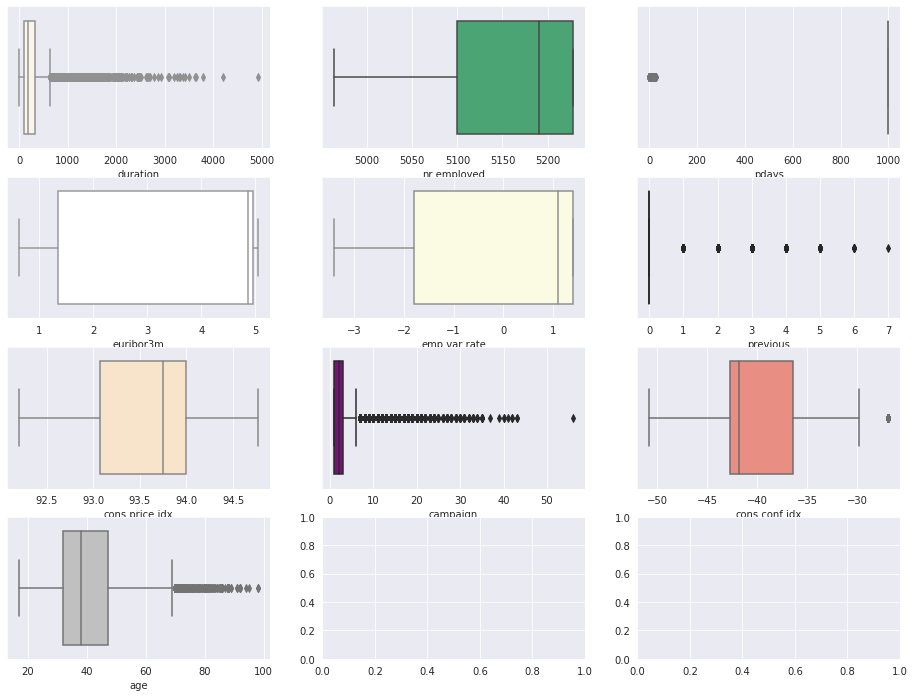

In [7]:
import random
from matplotlib.colors import cnames
corr = df.corr()['deposit'].abs().sort_values(ascending=False)
h_corr_cols = corr[corr < 1].index.tolist()
colors = list(cnames.keys())
sns.set_style('darkgrid')
fig , ax = plt.subplots(4,3,figsize = (16,12))
ax = ax.ravel()
for i,col in enumerate(h_corr_cols):
    sns.boxplot(df[col], ax = ax[i],color = random.choice(colors))

In [8]:
x = df[h_corr_cols].values
model = KNN(contamination=.1)
model.fit(x)
predicted = model.predict(x)

outliers = df.loc[(predicted == 1),:]
inliers = df.loc[(predicted == 0),:]

In [9]:
df = df.drop(index = df.loc[(predicted == 1),:].index )

###### Treating imbalance data

In [10]:
df.education.value_counts().to_frame()

,education
university.degree,10978
high.school,8755
basic.9y,5699
professional.course,4781
basic.4y,3700
basic.6y,2180
unknown,1491
illiterate,16


In [11]:
df['education'].replace({'basic.9y': 'basic','basic.4y': 'basic','basic.6y':'basic'},inplace=True)

In [12]:
df['education'].value_counts().to_frame() 

,education
basic,11579
university.degree,10978
high.school,8755
professional.course,4781
unknown,1491
illiterate,16


In [13]:
df.job.value_counts().to_frame()

,job
admin.,9493
blue-collar,8859
technician,6266
services,3760
management,2691
entrepreneur,1373
self-employed,1315
retired,1111
housemaid,961
unemployed,888


In [14]:
df['job'].replace({'entrepreneur': 'self-employed', 'technician': 'blue-collar',
                   'admin.': 'white-collar', 'management': 'white-collar',
                  'services': 'pink-collar', 'housemaid': 'pink-collar'}, inplace=True)

In [15]:
df.job.value_counts().to_frame()

,job
blue-collar,15125
white-collar,12184
pink-collar,4721
self-employed,2688
retired,1111
unemployed,888
student,596
unknown,287


In [16]:
df.shape

(37600, 21)

In [17]:
# categorical columns
# OneHotEncoding
cat_cols = df.select_dtypes(include=[
        'object']).columns
df = pd.get_dummies(df, columns=cat_cols)

In [18]:
#standard Scaler for Numerical Variables
scaler = StandardScaler()
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_cols = num_cols.drop('deposit')
df[num_cols] = scaler.fit_transform(df[num_cols])

In [19]:
df.head(2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,1.734565,0.165454,-0.602919,0.076012,-0.315927,0.579505,0.728214,0.966856,0.642695,0.224755,...,0,0,0,1,0,0,0,0,1,0
1,1.839917,-0.407251,-0.602919,0.076012,-0.315927,0.579505,0.728214,0.966856,0.642695,0.224755,...,0,0,0,1,0,0,0,0,1,0


In [20]:
df.shape

(37600, 58)

In [21]:
X = df.drop(columns=['duration', 'deposit'])
y = df['deposit']
print(X.shape)
print(y.shape)

(37600, 56)
(37600,)


In [22]:
y.value_counts().to_frame()  

,deposit
0,34895
1,2705


In [23]:
sampler = RandomOverSampler(random_state=42)

X_sampled, y_sampled = sampler.fit_resample(X, y)
pd.Series(y_sampled).value_counts().to_frame()

,deposit
1,34895
0,34895


###### Dimensionality Reduction: Principal Component Analysis

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
pca.fit(X_sampled)
X = pca.transform(X_sampled)


In [25]:
print(X_sampled.shape)
print(y_sampled.shape)
print(X.shape)

(69790, 56)
(69790,)
(69790, 10)


In [32]:
df_y = pd.DataFrame(data = y_sampled, columns = ['deposit'])

df_X = pd.DataFrame(data = X, columns = ['PC_1', 'PC_2','PC_3', 'PC_4','PC_5','PC_6', 'PC_7','PC_8', 'PC_9','PC_10'])
df_X

In [27]:
df_y.to_csv('../data/processed/results.csv', index=False)
df_X.to_csv('../data/processed/features.csv', index=False)